In [3]:
import tensorflow as tf
import keras
from keras.models import load_model
from main import df_val
from metrics import auc_roc
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

CHECKPOINTS_PATH = "output/"
MODEL_CLASSES= ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                'Lung Opacity',
                'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                'Support Devices']

def _load_model(checkpoint_name):
	return load_model(CHECKPOINTS_PATH+checkpoint_name, custom_objects={'auc_roc': auc_roc})

img_data_gen = keras.preprocessing.image.ImageDataGenerator(  # rotation_range=7,
    rescale=1 / 255)

val_gen = img_data_gen.flow_from_dataframe(df_val,
                                           directory=None,
                                           x_col='Path',
                                           y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                                                  'Lung Opacity',
                                                  'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                                                  'Atelectasis',
                                                  'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                                                  'Support Devices'],
                                           target_size=(331, 331),
                                           color_mode='grayscale',
                                           class_mode='raw',
                                           batch_size=64,
                                           shuffle=False,
                                           interpolation='box')

Found 234 validated image filenames.


In [38]:
df_val.sum(axis=0)

Path                          CheXpert-v1.0-small/valid/patient64541/study1/...
Sex                           MaleMaleMaleMaleFemaleFemaleMaleMaleMaleMaleFe...
Age                                                                       14225
Frontal/Lateral               FrontalFrontalLateralFrontalFrontalFrontalFron...
No Finding                                                                   38
Enlarged Cardiomediastinum                                                  109
Cardiomegaly                                                                 68
Lung Opacity                                                                126
Lung Lesion                                                                   1
Edema                                                                        45
Consolidation                                                                33
Pneumonia                                                                     8
Atelectasis                             

In [22]:
model_checkpoints = os.listdir(CHECKPOINTS_PATH)
#for checkpoint in model_checkpoints:


print("loading model...")
model_file = model_checkpoints[1]
model = _load_model("/model_durchlauf2_LARGE.10-1.33.h5")
print(f"{model_file} loaded successfully.")



loading model...
model_durchlauf2_LARGE.01-0.61.h5 loaded successfully.


In [24]:

print("Predicting...")
preds = model.predict_generator(val_gen)

Predicting...


In [25]:
import numpy as np
df_preds = pd.DataFrame(np.array(preds[0]), columns=MODEL_CLASSES)
df_truth = df_val.iloc[:,5:]

In [43]:
df_preds.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.140462,0.075038,0.252458,0.306384,0.054891,0.185511,0.068920,0.060028,0.174468,0.032973,0.036186,0.014277,0.049569,0.077480
1,0.458039,0.072882,0.017009,0.144518,0.089448,0.004221,0.039817,0.023494,0.041005,0.036260,0.105806,0.028578,0.028863,0.266555
2,0.573729,0.107021,0.036277,0.095126,0.039556,0.006283,0.039731,0.012257,0.048826,0.015751,0.062726,0.019455,0.037723,0.860166
3,0.015184,0.193179,0.154657,0.750982,0.187508,0.230720,0.134740,0.221940,0.089892,0.085977,0.276463,0.109280,0.121054,0.117760
4,0.411309,0.029954,0.005202,0.149838,0.058219,0.016115,0.028924,0.032673,0.052431,0.243986,0.023893,0.009379,0.037324,0.108235


In [45]:
df_truth.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cardiomegaly auc 0.7882707299787385
Edema auc 0.908641975308642
Consolidation auc 0.8882858435097242
Atelectasis auc 0.8050324675324676
Pleural Effusion auc 0.927786218607561


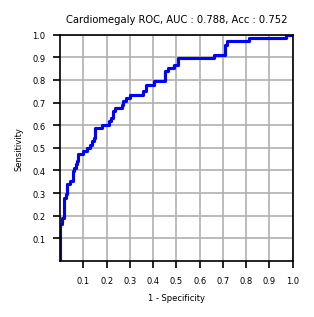

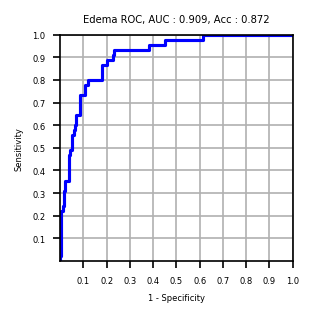

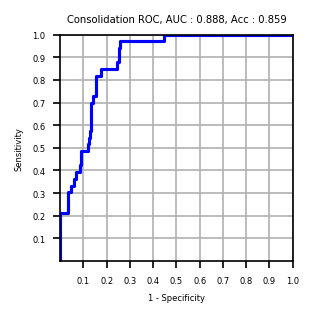

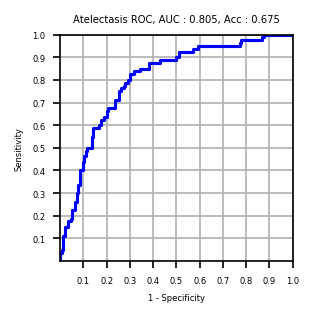

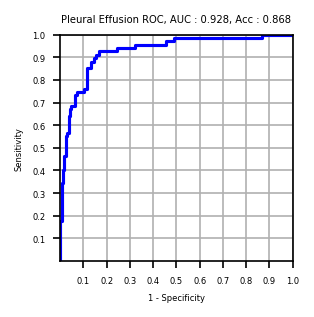

In [29]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_10"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

## Old Benchmark (MobileNAS)

Cardiomegaly auc 0.7600992204110559
Edema auc 0.897119341563786
Consolidation auc 0.8655208804462535
Atelectasis auc 0.8060876623376624
Pleural Effusion auc 0.9106265081776744


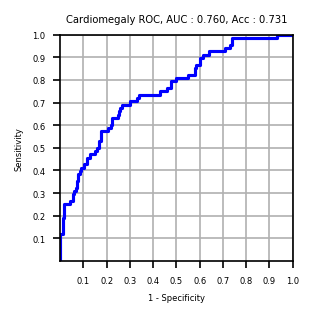

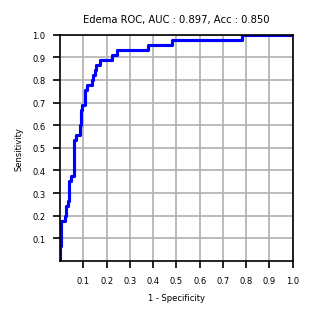

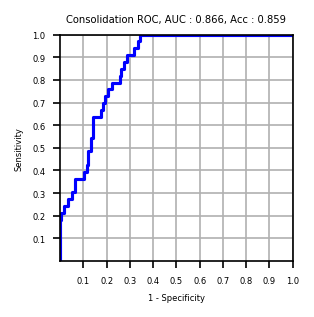

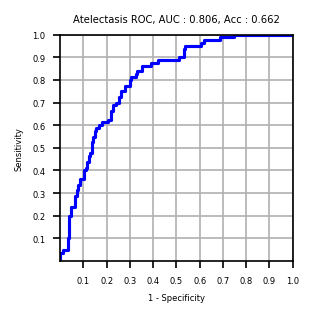

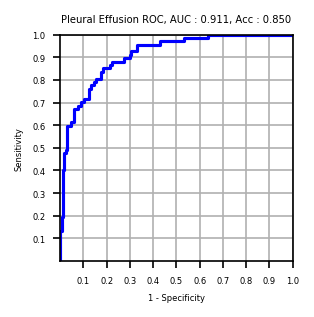

In [77]:
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 4})

benchmark_classes = ['Cardiomegaly', 'Edema','Consolidation','Atelectasis','Pleural Effusion']
for class_label in benchmark_classes:
    i = df_truth.columns.tolist().index(class_label)
    #label = [7,10,11,13,15]#header[i]
    y_pred = df_preds.iloc[:, i].values
    y_true = df_truth.iloc[:, i].values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(class_label, 'auc', auc)
    acc = metrics.accuracy_score(
        y_true, (y_pred >= 0.5).astype(int), normalize=True
    )

    plt.figure(figsize=(2, 2), dpi=150)
    plt.xlim((0, 1.0))
    plt.ylim((0, 1.0))
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('{} ROC, AUC : {:.3f}, Acc : {:.3f}'.format(class_label, auc, acc))
    plt.plot(fpr, tpr, '-b')
    
    plt.grid()
    plt.savefig(
        os.path.join("./", "Epoch_45"
                     + '_' + MODEL_CLASSES[i] + '_roc.png'), bbox_inches='tight')

In [59]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(df_truth, df_preds.round(0))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

ValueError: multilabel-indicator is not supported

In [57]:
df_preds.round(0).sum().sum()

361.0

In [58]:
df_truth.sum().sum()

691.0